Import libraries

In [479]:
import pandas as pd
import numpy as np
import talib
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

Fetch Historical data for the AAPL stock

In [480]:
# Fetch data for a specific stock
ticker = "AAPL"
start_date = datetime.strptime("2020-12-25", "%Y-%m-%d")
end_date = datetime.strptime("2025-01-28", "%Y-%m-%d")
stock_data = yf.download(ticker, start=start_date, end=end_date)
stock_data.reset_index(inplace=True)

# Inspect the data
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

Price        Date       Close        High         Low        Open     Volume
Ticker                   AAPL        AAPL        AAPL        AAPL       AAPL
0      2020-12-28  133.662994  134.298594  130.553408  131.022789  124486200
1      2020-12-29  131.883316  135.716506  131.365054  134.992903  121047300
2      2020-12-30  130.758759  132.978493  130.445838  132.577569   96452100
3      2020-12-31  129.751587  131.756193  128.803066  131.110805   99116600
4      2021-01-04  126.544205  130.651192  123.952888  130.563189  143301900


Get RSI

In [481]:
# Fill missing values in the 'Close' column first
stock_data['Close'] = stock_data['Close'].fillna(method='ffill')  # Forward-fill missing values
stock_data['Close'] = stock_data['Close'].fillna(method='bfill')  # Backward-fill if forward-fill is insufficient

# Calculate RSI after filling 'Close'
stock_data['RSI'] = talib.RSI(stock_data['Close'].values.flatten(), timeperiod=14)

# Fill the first 14 rows of RSI with the 15th row value
first_valid_rsi = stock_data.loc[14, 'RSI']  # Get the RSI value from the 15th row
stock_data.loc[:13, 'RSI'] = first_valid_rsi  # Fill the first 14 rows with this value

# Print the RSI column to verify
print(stock_data['RSI'].iloc[14])
stock_data.loc[:13, 'RSI'] = stock_data['RSI'].iloc[14]

print(stock_data['RSI'])

34.467132277911375
0       34.467132
1       34.467132
2       34.467132
3       34.467132
4       34.467132
          ...    
1019    35.403532
1020    29.697473
1021     31.62165
1022    31.489059
1023    30.769808
Name: RSI, Length: 1024, dtype: object


/var/folders/hv/2vlnl85n369fmvwhjtsktpsh0000gn/T/ipykernel_11868/3407466581.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['Close'] = stock_data['Close'].fillna(method='ffill')  # Forward-fill missing values
/var/folders/hv/2vlnl85n369fmvwhjtsktpsh0000gn/T/ipykernel_11868/3407466581.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['Close'] = stock_data['Close'].fillna(method='bfill')  # Backward-fill if forward-fill is insufficient
/var/folders/hv/2vlnl85n369fmvwhjtsktpsh0000gn/T/ipykernel_11868/3407466581.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dty

Get SMA

In [482]:
stock_data['SMA50'] = talib.SMA(stock_data['Close'].values.flatten(), timeperiod=50)
stock_data['SMA20'] = talib.SMA(stock_data['Close'].values.flatten(), timeperiod=20)

print(stock_data['SMA50'])
print(stock_data['SMA50'].shape)

print(stock_data['SMA20'])
print(stock_data['SMA20'].shape)

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
1019    239.281792
1020    239.270504
1021    239.297599
1022    239.226199
1023    239.142599
Name: SMA50, Length: 1024, dtype: float64
(1024,)
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
1019    245.039500
1020    243.768999
1021    242.471000
1022    240.929500
1023    239.305000
Name: SMA20, Length: 1024, dtype: float64
(1024,)


Find the Bollinger Band (BB Indicator)

In [483]:
stock_data['UpperBB'], stock_data['MiddleBB'], stock_data['LowerBB'] = talib.BBANDS(
    stock_data['Close'].values.flatten(), timeperiod=20
)


# Ensure there are no NaN for UpperBB
stock_data.loc[0:20, 'UpperBB'] = stock_data['UpperBB'].iloc[19]
print(stock_data['UpperBB'])


# Ensure there are no NanN for LowerBB
stock_data.loc[0:20, 'LowerBB'] = stock_data['LowerBB'].iloc[19]
print(stock_data['LowerBB'])


# Ensure there are no NanN for MiddleBB
stock_data.loc[0:20, 'MiddleBB'] = stock_data['MiddleBB'].iloc[19]
print(stock_data['MiddleBB'])



0       139.062695
1       139.062695
2       139.062695
3       139.062695
4       139.062695
           ...    
1019    263.379651
1020    264.467776
1021    264.696265
1022    263.871534
1023    262.554339
Name: UpperBB, Length: 1024, dtype: float64
0       120.514789
1       120.514789
2       120.514789
3       120.514789
4       120.514789
           ...    
1019    226.699349
1020    223.070223
1021    220.245735
1022    217.987466
1023    216.055660
Name: LowerBB, Length: 1024, dtype: float64
0       129.788742
1       129.788742
2       129.788742
3       129.788742
4       129.788742
           ...    
1019    245.039500
1020    243.768999
1021    242.471000
1022    240.929500
1023    239.305000
Name: MiddleBB, Length: 1024, dtype: float64


Create a trading strategy with BB, SMA, and RSI and create buy or sell signals.

In [484]:
print(stock_data[['RSI', 'Close', 'LowerBB', 'UpperBB']].info())
print(stock_data.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (RSI, )        1024 non-null   object 
 1   (Close, AAPL)  1024 non-null   float64
 2   (LowerBB, )    1024 non-null   float64
 3   (UpperBB, )    1024 non-null   float64
dtypes: float64(3), object(1)
memory usage: 32.1+ KB
None
MultiIndex([(    'Date',     ''),
            (   'Close', 'AAPL'),
            (    'High', 'AAPL'),
            (     'Low', 'AAPL'),
            (    'Open', 'AAPL'),
            (  'Volume', 'AAPL'),
            (     'RSI',     ''),
            (   'SMA50',     ''),
            (   'SMA20',     ''),
            ( 'UpperBB',     ''),
            ('MiddleBB',     ''),
            ( 'LowerBB',     '')],
           names=['Price', 'Ticker'])


In [485]:
# Flatten the MultiIndex
stock_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in stock_data.columns]

# Verify the flattened column names
print(stock_data.columns)

# Initialize Signal column
stock_data['Signal_T'] = 0  # Default to no action

# Generate Buy and Sell Signals
stock_data.loc[
    (stock_data['RSI_'] < 30) & (stock_data[f'Close_{ticker}'] < stock_data['LowerBB_']),
    'Signal_T'
] = 1  # Buy signal

stock_data.loc[
    (stock_data['RSI_'] > 70) & (stock_data[f'Close_{ticker}'] > stock_data['UpperBB_']),
    'Signal_T'
] = -1  # Sell signal

# Verify the result
print(stock_data[['Date_', f'Close_{ticker}', 'RSI_', 'Signal_T']])

# Filter rows where Signal is 1 or -1
filtered_data = stock_data[(stock_data['Signal_T'] == 1) | (stock_data['Signal_T'] == -1)]

# Print the filtered rows
print(filtered_data)

Index(['Date_', 'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL',
       'Volume_AAPL', 'RSI_', 'SMA50_', 'SMA20_', 'UpperBB_', 'MiddleBB_',
       'LowerBB_'],
      dtype='object')
          Date_  Close_AAPL       RSI_  Signal_T
0    2020-12-28  133.662994  34.467132         0
1    2020-12-29  131.883316  34.467132         0
2    2020-12-30  130.758759  34.467132         0
3    2020-12-31  129.751587  34.467132         0
4    2021-01-04  126.544205  34.467132         0
...         ...         ...        ...       ...
1019 2025-01-17  229.979996  35.403532         0
1020 2025-01-21  222.639999  29.697473         1
1021 2025-01-22  223.830002   31.62165         0
1022 2025-01-23  223.660004  31.489059         0
1023 2025-01-24  222.779999  30.769808         0

[1024 rows x 4 columns]
          Date_  Close_AAPL   High_AAPL    Low_AAPL   Open_AAPL  Volume_AAPL  \
40   2021-02-25  118.487465  123.844326  118.046776  122.101144    148199500   
41   2021-02-26  118.751884  122.267626  1

Plot the signals

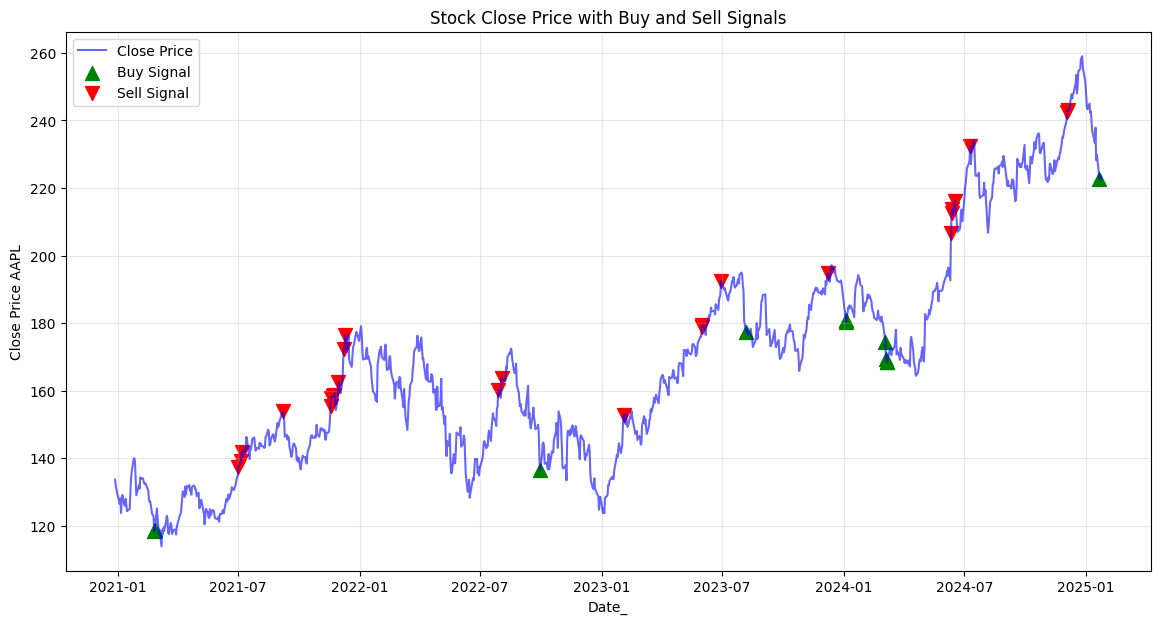

In [486]:
import matplotlib.pyplot as plt

# Filter rows with buy and sell signals
buy_signals = stock_data[stock_data['Signal_T'] == 1]
sell_signals = stock_data[stock_data['Signal_T'] == -1]

# Plot the stock's Close price
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Date_'], stock_data[f'Close_{ticker}'], label='Close Price', color='blue', alpha=0.6)

# Add buy signals to the plot
plt.scatter(buy_signals['Date_'], buy_signals[f'Close_{ticker}'], label='Buy Signal', marker='^', color='green', s=100)

# Add sell signals to the plot
plt.scatter(sell_signals['Date_'], sell_signals[f'Close_{ticker}'], label='Sell Signal', marker='v', color='red', s=100)

# Plot enhancements
plt.title('Stock Close Price with Buy and Sell Signals')
plt.xlabel('Date_')
plt.ylabel(f'Close Price {ticker}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Integrate SMA Indicator Strategy
- If SMA 50 > SMA 200: Buy Indicator
- If SMA 50 < SMA 200: Sell Indicator


In [487]:
# Create label for SMA Buy or Sell.
# 1 = Buy
# 0 = Hold
# -1 = Sell
sma_label = 0

# Get SMA50 and SMA200
stock_data[f"SMA50_{ticker}"] = stock_data[f"Close_{ticker}"].rolling(window=50).mean()
stock_data[f"SMA200_{ticker}"] = stock_data[f"Close_{ticker}"].rolling(window=200).mean()

stock_data['sma_label'] = 0

# Label signals
stock_data.loc[(stock_data[f"SMA50_{ticker}"] > stock_data[f"SMA200_{ticker}"]), 'sma_label'] = 1
stock_data.loc[(stock_data[f"SMA50_{ticker}"] < stock_data[f"SMA200_{ticker}"]), 'sma_label'] = -1

If SMA label and previous Signal labels are equal, we buy or sell.

In [488]:


# Generate Buy Signal: RSI < 30, Close below Lower Bollinger Band, and SMA Buy
stock_data.loc[
    (stock_data['Signal_T'] == 1) &
    (stock_data['sma_label'] == 1),
    'Signal'
] = 1  # Buy signal

# Generate Sell Signal: RSI > 70, Close above Upper Bollinger Band, and SMA Sell
stock_data.loc[
    (stock_data['Signal_T'] == -1) &
    (stock_data['sma_label'] == -1),
    'Signal'
] = -1  # Sell signal

stock_data['Signal'] = stock_data['Signal'].fillna(0)


# Save the DataFrame to a CSV file
stock_data.to_csv('stock_data.csv', index=False)

print("Data saved to 'stock_data.csv'")


Data saved to 'stock_data.csv'


Plot the signals

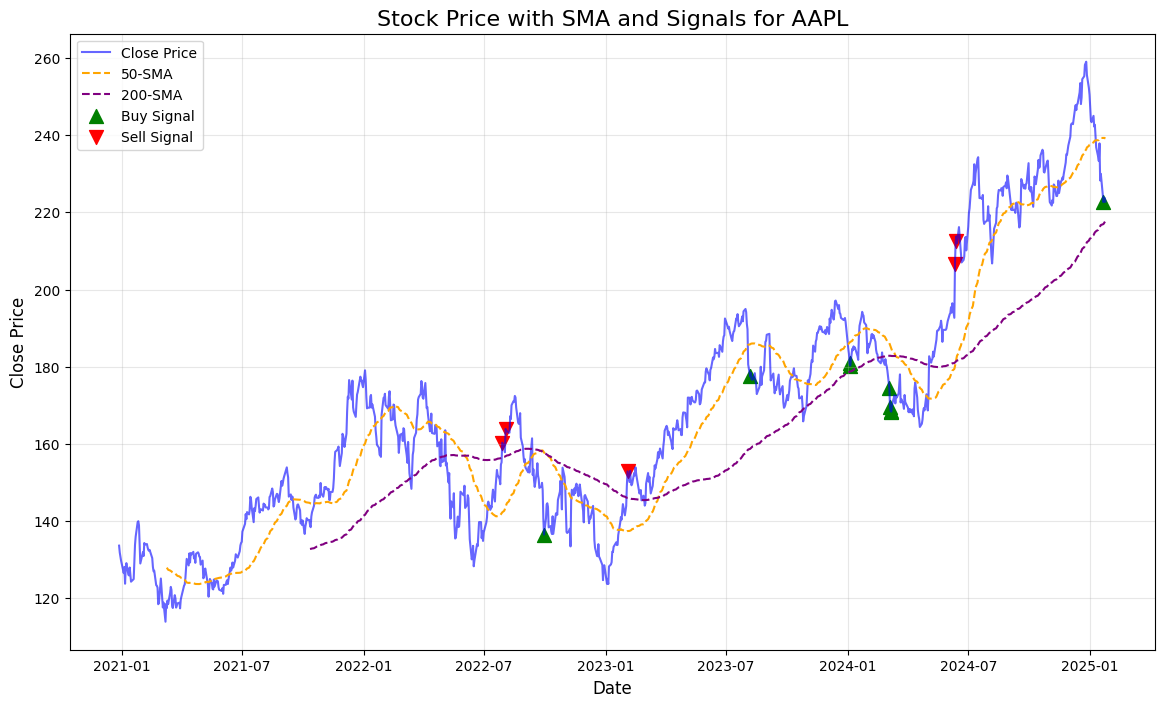

In [489]:
import matplotlib.pyplot as plt

# Plot Close Price
plt.figure(figsize=(14, 8))
plt.plot(stock_data['Date_'], stock_data[f"Close_{ticker}"], label='Close Price', color='blue', alpha=0.6)

# Add SMA50 and SMA200
plt.plot(stock_data['Date_'], stock_data[f"SMA50_{ticker}"], label='50-SMA', color='orange', linestyle='--')
plt.plot(stock_data['Date_'], stock_data[f"SMA200_{ticker}"], label='200-SMA', color='purple', linestyle='--')

# Highlight Buy and Sell signals
buy_signals = stock_data[stock_data['Signal'] == 1]
sell_signals = stock_data[stock_data['Signal'] == -1]
plt.scatter(buy_signals['Date_'], buy_signals[f"Close_{ticker}"], label='Buy Signal', marker='^', color='green', s=100)
plt.scatter(sell_signals['Date_'], sell_signals[f"Close_{ticker}"], label='Sell Signal', marker='v', color='red', s=100)

# Add titles and labels
plt.title(f'Stock Price with SMA and Signals for {ticker}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

### Utilize Hugging Face for Sentiment Analysis on News Outlets

Load the sentiment analysis pipeline

In [490]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import requests

pipe = pipeline("sentiment-analysis", model="ProsusAI/finbert")


tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")


Device set to use mps:0


Fetch news headlines using NewsAPI for a ticker

In [491]:


NEWS_API_KEY = "927e1bf828ac45beac4ee886d8e2c2d4"
NEWS_API_URL = "https://newsapi.org/v2/everything"

def get_news(company, ticker):
    
    params = {
        "q": f'"{company}" OR "{ticker}" AND (earnings OR revenue OR profits OR market OR stocks)',
        "language": "en",
        "sortBy": "relevancy",
        "apiKey": NEWS_API_KEY,
    }

    response = requests.get(NEWS_API_URL, params=params)
    if response.status_code == 200:
        articles = response.json().get("articles", [])
        # Extract headlines and publication dates
        headlines_with_dates = [
            {"headline": article["title"], "date": article["publishedAt"]}
            for article in articles
        ]
        return headlines_with_dates
    else:
        print(f"Error fetching news: {response.status_code}")
        return []

# Fetch news data
company = "NVIDIA"

# Fetch news data
news_data = get_news(company, ticker)

# Display the news articles with their dates
for news in news_data:
    print(f"Date: {news['date']}, Headline: {news['headline']}")



Date: 2025-01-13T19:12:13Z, Headline: Why Tech Stocks Are Dropping Monday
Date: 2024-12-26T17:52:35Z, Headline: Stock market today: Dow ekes out gains, bitcoin slumps as 'Santa Claus' rally takes a pause
Date: 2025-01-23T17:41:05Z, Headline: What matters most for AAPL shares next week
Date: 2025-01-07T15:08:41Z, Headline: Micron (MU) Stock Jumps for Second Day After Nvidia (NVDA) Mention
Date: 2024-12-27T17:24:42Z, Headline: Analyst on NVIDIA (NVDA): Investors Should Be ‘Very Vigilant’ Amid Rising Competition
Date: 2024-12-27T13:58:10Z, Headline: Apple Set to Become First $4 Trillion Company
Date: 2024-12-31T10:00:00Z, Headline: The AI stocks that could boom in 2025
Date: 2024-12-27T17:44:00Z, Headline: The Dow sinks 500 points as Nvidia and Tesla lead tech decline
Date: 2025-01-13T16:21:18Z, Headline: Nvidia and other AI stocks are bleeding after Biden issued new AI rules
Date: 2025-01-21T20:11:04Z, Headline: Nvidia is the world's most valuable company again as Apple stock slips
Date:

Analyze Sentiment using Finbert

In [492]:
def analyze_sentiment(news_data):
    for article in news_data:
        sentiment = pipe(article["headline"])[0]
        article["sentiment"] = sentiment["label"]
        article["score"] = sentiment["score"]
    return news_data

In [493]:
def group_sentiment_by_day(news_data):
    # Convert publication dates to datetime and group by day
    for article in news_data:
        article["day"] = datetime.strptime(article["date"], "%Y-%m-%dT%H:%M:%SZ").strftime('%Y-%m-%d')
    
    # Create a DataFrame
    df = pd.DataFrame(news_data)
    
    # Group by day and calculate sentiment stats
    daily_sentiment = (
        df.groupby("day")
        .agg({"score": "mean", "headline": "count", "sentiment": lambda x: x.mode()[0]})
        .rename(columns={"headline": "article_count", "score": "average_sentiment"})
        .reset_index()
    )
    return daily_sentiment

In [494]:
news_data = get_news(company, ticker)

# Analyze sentiment and group by day
if news_data:
    news_data = analyze_sentiment(news_data)
    daily_sentiment = group_sentiment_by_day(news_data)
    
    # Display results
    print(daily_sentiment)
else:
    print("No news articles found.")

           day  average_sentiment  article_count sentiment
0   2024-12-26           0.828730              6  negative
1   2024-12-27           0.842310              6   neutral
2   2024-12-30           0.931635              5  negative
3   2024-12-31           0.777649              4  negative
4   2025-01-01           0.792007              1  positive
5   2025-01-02           0.781512              6  negative
6   2025-01-03           0.755180              5   neutral
7   2025-01-05           0.904319              1   neutral
8   2025-01-06           0.650287              3  negative
9   2025-01-07           0.382675              1  positive
10  2025-01-08           0.882874              1  positive
11  2025-01-09           0.748740              3   neutral
12  2025-01-10           0.823526              6   neutral
13  2025-01-11           0.601729              1   neutral
14  2025-01-12           0.759142              3  negative
15  2025-01-13           0.890144             10  negati